In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

In [5]:

fake['target'] = 'fake'
true['target'] = 'true'

In [6]:

data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:

from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:

data.head()

,title,text,subject,date,target
0,Trump’s Awkward First Date with Frau Merkel,21st Century Wire says It was an awkward fit o...,Middle-east,"March 18, 2017",fake
1,Dan Rather: Trump’s First Two Months In Offic...,Legendary newsman Dan Rather has lived through...,News,"March 27, 2017",fake
2,Trump’s Creepy Obsession With Waterboarding G...,Trump responded to yesterday s tragic suicide ...,News,"June 29, 2016",fake
3,Anti-Gun Hypocrites Bash David Beckham’s Son f...,David Beckham s son posed with a gun in a mode...,left-news,"Sep 4, 2017",fake
4,You’ll Never Guess Which Conservative Blowhar...,"As you re probably aware already, Donald Trump...",News,"January 8, 2016",fake


In [9]:

data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Trump’s Awkward First Date with Frau Merkel,21st Century Wire says It was an awkward fit o...,Middle-east,fake
1,Dan Rather: Trump’s First Two Months In Offic...,Legendary newsman Dan Rather has lived through...,News,fake
2,Trump’s Creepy Obsession With Waterboarding G...,Trump responded to yesterday s tragic suicide ...,News,fake
3,Anti-Gun Hypocrites Bash David Beckham’s Son f...,David Beckham s son posed with a gun in a mode...,left-news,fake
4,You’ll Never Guess Which Conservative Blowhar...,"As you re probably aware already, Donald Trump...",News,fake


In [10]:

data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,21st Century Wire says It was an awkward fit o...,Middle-east,fake
1,Legendary newsman Dan Rather has lived through...,News,fake
2,Trump responded to yesterday s tragic suicide ...,News,fake
3,David Beckham s son posed with a gun in a mode...,left-news,fake
4,"As you re probably aware already, Donald Trump...",News,fake


In [11]:

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,21st century wire says it was an awkward fit o...,Middle-east,fake
1,legendary newsman dan rather has lived through...,News,fake
2,trump responded to yesterday s tragic suicide ...,News,fake
3,david beckham s son posed with a gun in a mode...,left-news,fake
4,"as you re probably aware already, donald trump...",News,fake


In [12]:

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:

data.head()

,text,subject,target
0,21st century wire says it was an awkward fit o...,Middle-east,fake
1,legendary newsman dan rather has lived through...,News,fake
2,trump responded to yesterday s tragic suicide ...,News,fake
3,david beckham s son posed with a gun in a mode...,left-news,fake
4,as you re probably aware already donald trump ...,News,fake


In [14]:

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [15]:
data.head()

,text,subject,target
0,21st century wire says awkward fit nerves dona...,Middle-east,fake
1,legendary newsman dan rather lived covered sev...,News,fake
2,trump responded yesterday tragic suicide bombi...,News,fake
3,david beckham son posed gun modeling photo sho...,left-news,fake
4,probably aware already donald trump released i...,News,fake


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


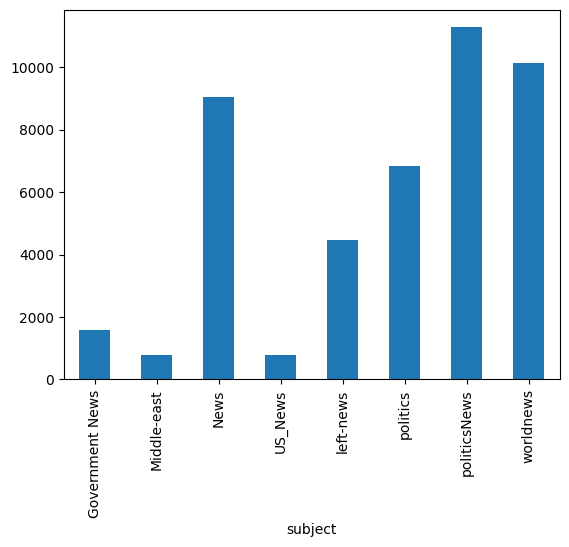

In [16]:

print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [17]:

from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

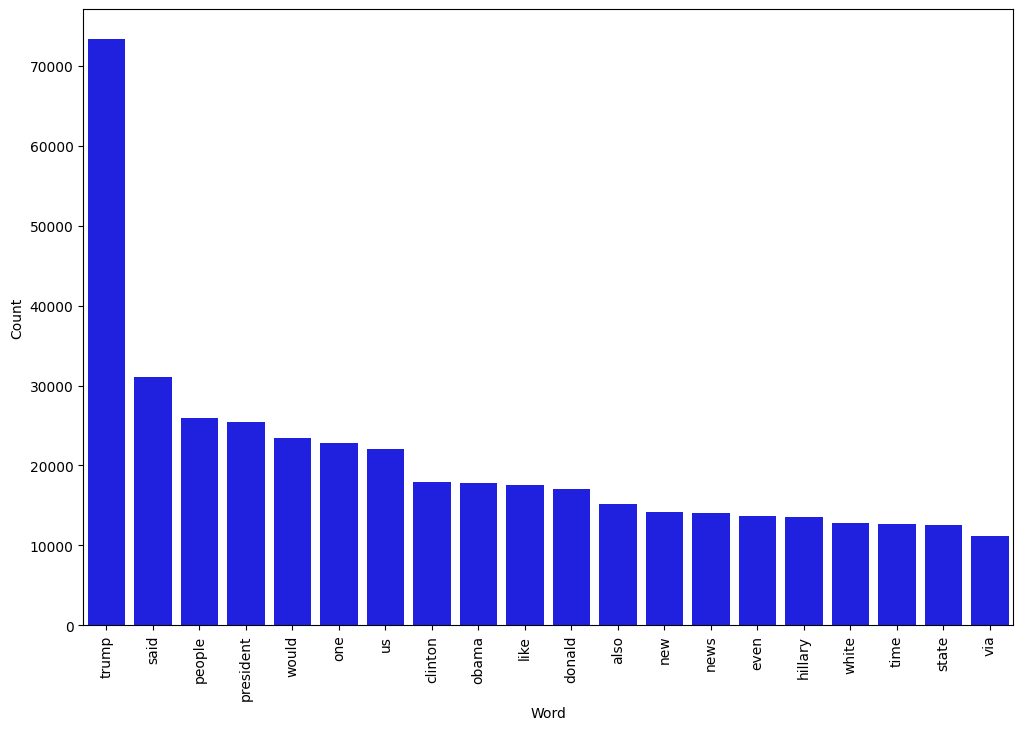

In [18]:

counter(data[data["target"] == "fake"], "text", 20)

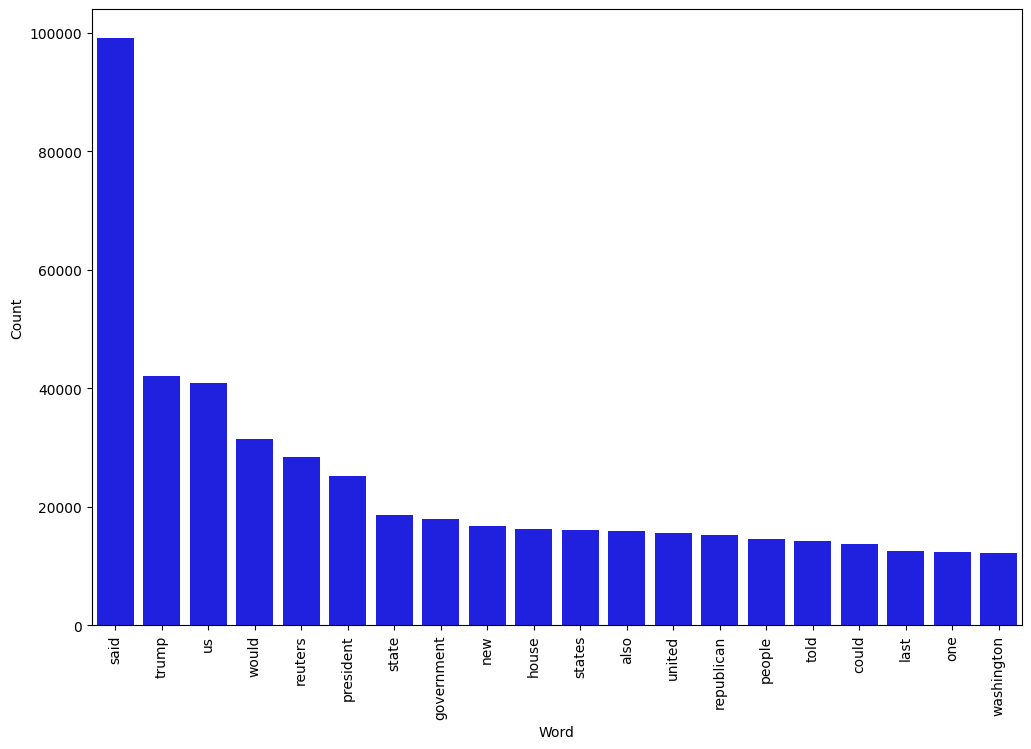

In [19]:

counter(data[data["target"] == "true"], "text", 20)

In [20]:

from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [22]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.23%


Confusion matrix, without normalization


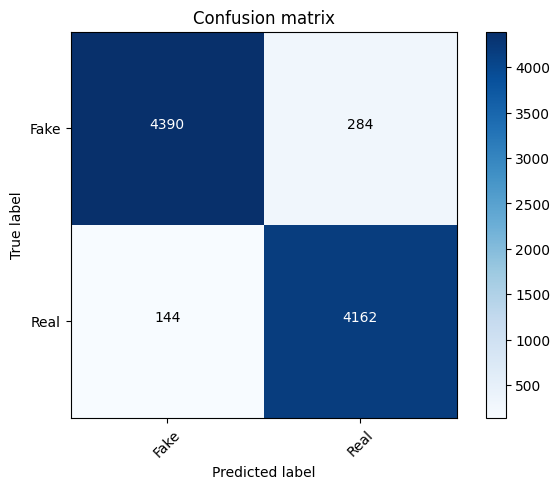

In [23]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [24]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.9%


Confusion matrix, without normalization


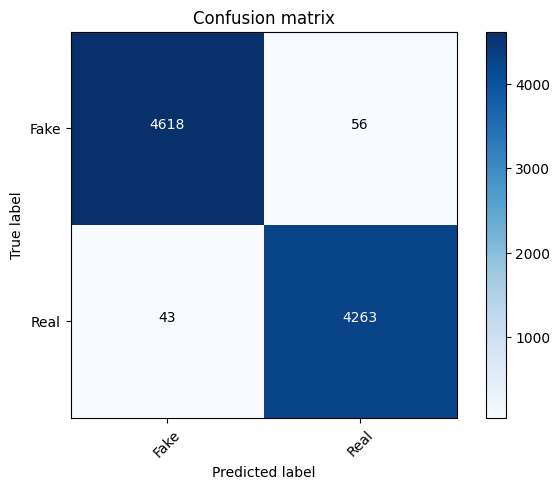

In [25]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [26]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.63%


Confusion matrix, without normalization


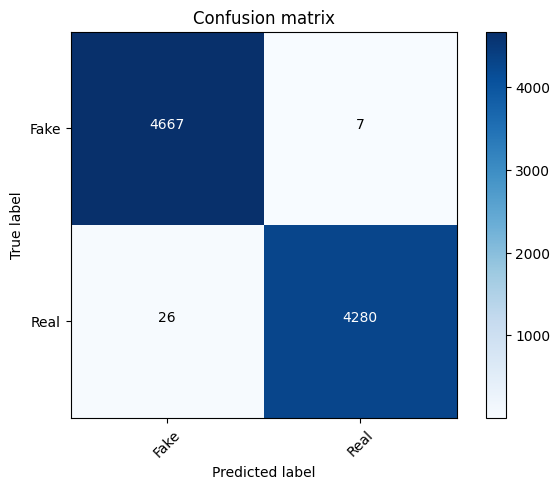

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [28]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.16%


Confusion matrix, without normalization


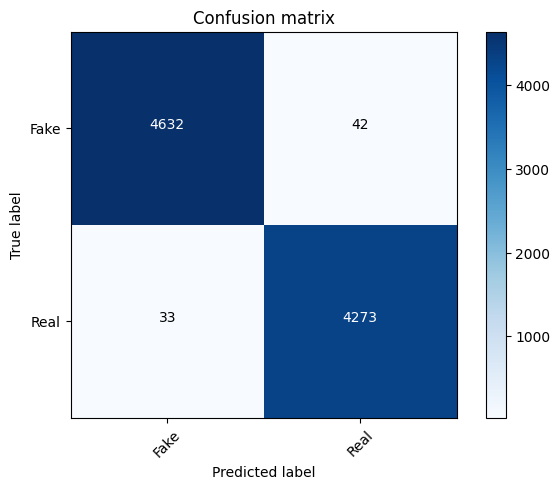

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [30]:
from sklearn import svm

clf = svm.SVC(kernel='linear')

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



accuracy: 99.54%


Confusion matrix, without normalization


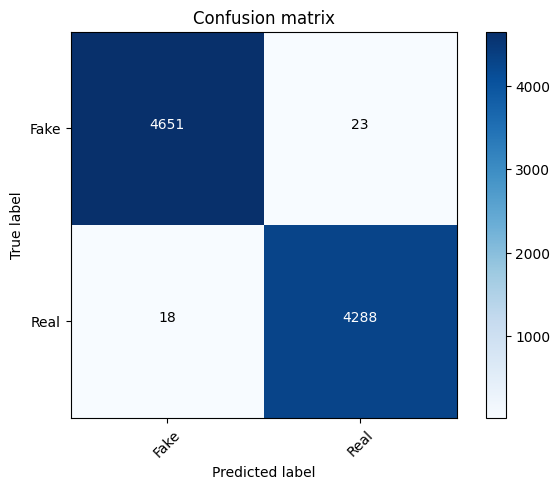

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

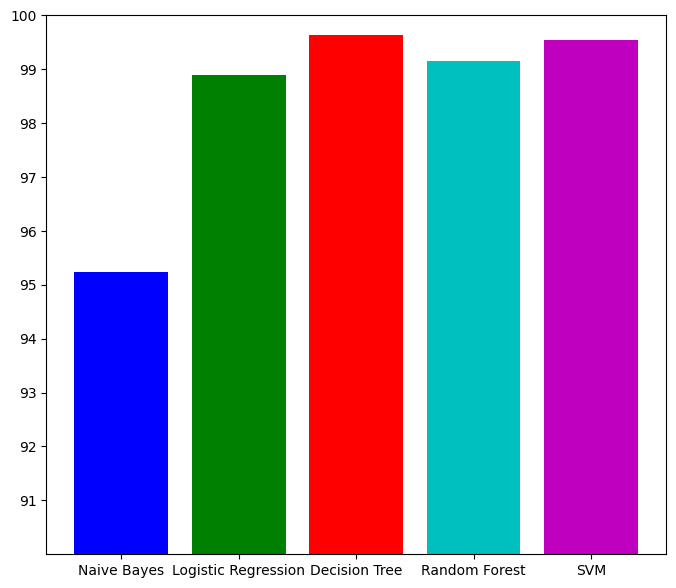

In [32]:
colors = ['b', 'g', 'r', 'c', 'm']
plt.figure(figsize=(8, 7))
plt.bar(list(dct.keys()), list(dct.values()), color=colors[:len(dct)])
plt.ylim(90, 100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))
plt.show()